# Tabular data: Play ground

Goal: check different approaches from classic to more recent DL in structured datasets.

Methods:
- Logistic regression
- Random forest
- XGBoost
- TabPFN
Dataset:
- Titanic (Kaggle)

In [1]:
!pip install tabpfn
!pip install pygam
!pip install ppscore

In [2]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from  sklearn.preprocessing import PowerTransformer
from  sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from sklearn.metrics import accuracy_score
import time  
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pygam import LinearGAM, s, f
import ppscore as pps
import xgboost as xgb
%matplotlib inline

In [3]:
full = pd.read_csv('data/train.csv', header = 0, dtype={'Age': np.float64})
holdout  = pd.read_csv('data/test.csv' , header = 0, dtype={'Age': np.float64})
merged = pd.concat([full, holdout])

print (merged.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB
None


In [4]:
merged.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [5]:
#merged.describe(exclude=[object])
# survived is the label class.
merged.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: xlabel='Sex', ylabel='Count'>

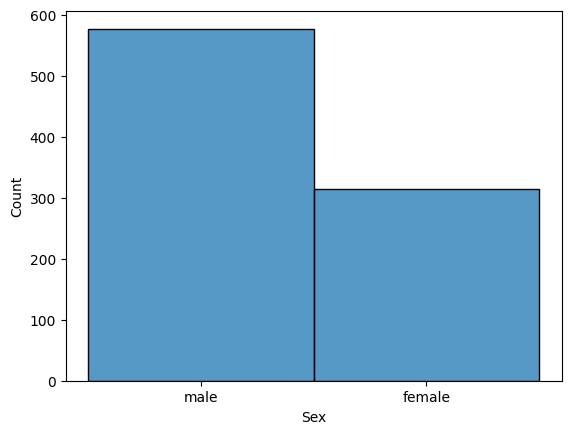

In [6]:
sns.histplot(data = full, x = "Sex")


Text(0.5, 1.0, 'Survival rate by Sex')

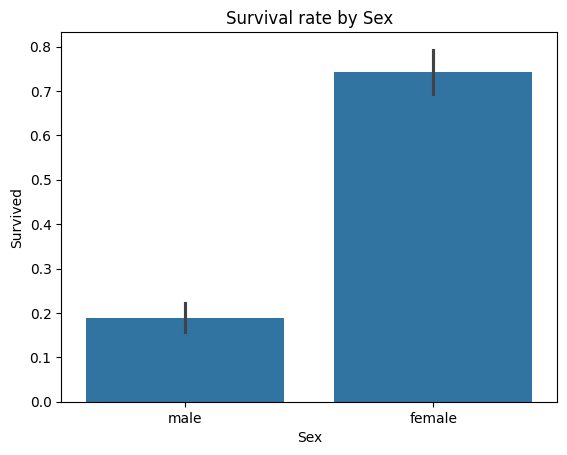

In [7]:
sns.barplot(data = full, x = "Sex", y = "Survived").set_title('Survival rate by Sex')


Text(0.5, 1.0, 'Survival rate by Pclass')

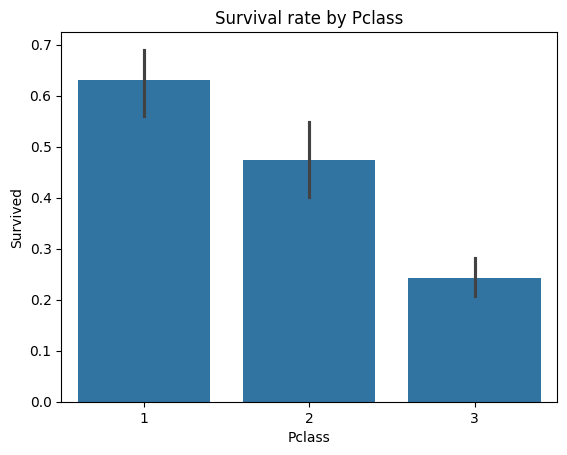

In [8]:
sns.barplot(data = full, x = "Pclass", y = "Survived").set_title('Survival rate by Pclass')


In [9]:
y = full.Survived
cols_with_missing = [col for col in merged.columns if merged[col].isnull().any()] 
X = full.copy()
print(X.info())
X.drop(cols_with_missing, axis=1, inplace=True)
X.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
X['Sex'] = X['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    float64
 1   Sex     891 non-nul

In [10]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print (x_train.info())
print (x_val.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 6 to 102
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  596 non-null    float64
 1   Sex     596 non-null    float64
 2   SibSp   596 non-null    float64
 3   Parch   596 non-null    float64
dtypes: float64(4)
memory usage: 23.3 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 709 to 173
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  295 non-null    float64
 1   Sex     295 non-null    float64
 2   SibSp   295 non-null    float64
 3   Parch   295 non-null    float64
dtypes: float64(4)
memory usage: 11.5 KB
None


## Logistic regression

In [43]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.linear_model import LogisticRegression

Train/Test split results:
LogisticRegression accuracy is 0.810
LogisticRegression log_loss is 0.437
LogisticRegression auc is 0.862


/var/folders/p2/kkyd0gbx0s5_9mbwn8jt2msc0000gq/T/ipykernel_40219/1680362613.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
/var/folders/p2/kkyd0gbx0s5_9mbwn8jt2msc0000gq/T/ipykernel_40219/1680362613.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')


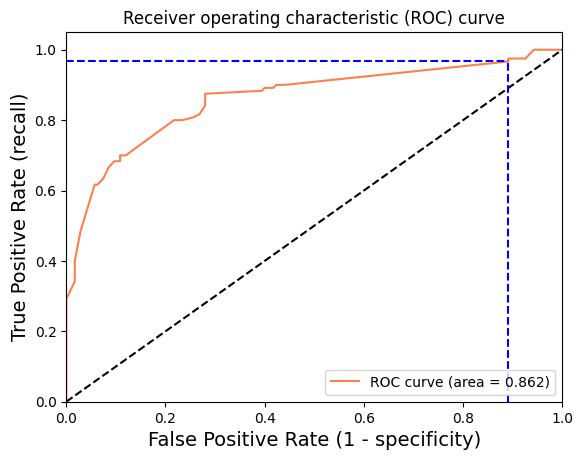

Using a threshold of 0.121 guarantees a sensitivity of 0.967 and a specificity of 0.109, i.e. a false positive rate of 89.14%.


In [45]:
# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
y_pred_proba = logreg.predict_proba(x_val)[:, 1]
[fpr, tpr, thr] = roc_curve(y_val, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_val, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

## Random forest

In [11]:
start_time = time.time()
model_rf = RandomForestClassifier(n_estimators = 100,max_depth=3)
model_rf = model_rf.fit(x_train, y_train)
start_pred_time = time.time()
predictions = model_rf.predict(x_val)
end_pred_time = time.time()
rf_val_acc = accuracy_score(y_val, predictions)
print('RandomForestClassifier validation accuracy', rf_val_acc)

end_time = time.time()
print("Execution time: ", end_time - start_time, "secs")
print("Prediction time:", end_pred_time - start_pred_time, "secs")

RandomForestClassifier validation accuracy 0.8135593220338984
Execution time:  0.049482107162475586 secs
Prediction time: 0.002192258834838867 secs


## XGBoost

In [23]:
x_train_xgb=x_train.values
x_val_xgb=x_val.values
y_train_xgb=y_train.values
y_val_xgb=y_val.values
negative_cases = sum(y_train == 0)
postive_cases = sum(y_train == 1)
negative_cases/postive_cases

1.6846846846846846

In [24]:
start_time = time.time()
model_xgb = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05,early_stopping_rounds=10,objective = "binary:logistic",
                             scale_pos_weight=negative_cases/postive_cases)
# Add silent=True to avoid printing out updates with each cycle
model_xgb.fit(x_train_xgb, y_train_xgb, verbose=False,
             eval_set=[(x_val_xgb, y_val_xgb)])
from sklearn.metrics import confusion_matrix, mean_squared_error
predictions = model_xgb.predict(x_val_xgb)
print(confusion_matrix(y_val_xgb, predictions))
print('XGBoost validation accuracy', accuracy_score(y_val_xgb, predictions))

end_time = time.time()
print("Execution time: ", end_time - start_time, "secs")
print("Prediction time:", end_pred_time - start_pred_time, "secs")

[[150  25]
 [ 31  89]]
XGBoost validation accuracy 0.8101694915254237
Execution time:  0.04413795471191406 secs
Prediction time: 0.002192258834838867 secs


In [38]:
from sklearn.model_selection import GridSearchCV

print("Parameter optimization")
xgb_model2 = xgb.XGBRegressor(n_jobs=1)
clf = GridSearchCV(
    xgb_model2,
    {"learning_rate":[0.01,0.05,0.1],
     "max_depth": [2, 3,4],
     "n_estimators": [50, 100,1000],
     "scale_pos_weight":[1,1.3,1.6846846846846846,2]},
    verbose=1,
    n_jobs=1,
    cv=3,
)
clf.fit(x_train_xgb, y_train_xgb, verbose=False,
             eval_set=[(x_val_xgb, y_val_xgb)])
print(clf.best_score_)
print(clf.best_params_)



Parameter optimization
Fitting 3 folds for each of 108 candidates, totalling 324 fits
0.38752055168151855
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'scale_pos_weight': 1}


In [28]:
start_time = time.time()
model_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1,
                              early_stopping_rounds=10,
                              objective = "binary:logistic",
                              scale_pos_weight=negative_cases/postive_cases)
# Add silent=True to avoid printing out updates with each cycle
model_xgb.fit(x_train_xgb, y_train_xgb, verbose=False,
             eval_set=[(x_val_xgb, y_val_xgb)])
from sklearn.metrics import confusion_matrix, mean_squared_error
predictions = model_xgb.predict(x_val_xgb)
print(confusion_matrix(y_val_xgb, predictions))
print('XGBoost validation accuracy', accuracy_score(y_val_xgb, predictions))
end_time = time.time()
print("Execution time: ", end_time - start_time, "secs")
print("Prediction time:", end_pred_time - start_pred_time, "secs")

[[150  25]
 [ 31  89]]
XGBoost validation accuracy 0.8101694915254237
Execution time:  0.057650089263916016 secs
Prediction time: 0.002192258834838867 secs


## DL: TapFPN

In [33]:
!pip install tensorflow

/opt/miniconda3/envs/dlfairness/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=40219) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 MB 10.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 13.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 15.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.4/394.4 kB 10.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 5.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.4 

In [46]:
import tensorflow as tf
tf.test.gpu_device_name()
# make use of apple silicon
tf.device("/gpu:0")

In [36]:
start_time = time.time()
model_dl = TabPFNClassifier(device="/gpu:0",N_ensemble_configurations=32)
model_dl = model.fit(x_train, y_train)
start_pred_time = time.time()
predictions = model_dl.predict(x_val.to_numpy())
end_pred_time = time.time()
tpfn_val_acc = accuracy_score(y_val, predictions)
print()
print('TabPFNClassifier validation accuracy', tpfn_val_acc)

end_time = time.time()
print("Execution time: ", end_time - start_time, "secs")
print("Prediction time:", end_pred_time - start_pred_time, "secs")

/opt/miniconda3/envs/dlfairness/lib/python3.12/site-packages/tabpfn/scripts/model_builder.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state, optimizer_state, 

Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


/opt/miniconda3/envs/dlfairness/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



TabPFNClassifier validation accuracy 0.8067796610169492
Execution time:  0.7615768909454346 secs
Prediction time: 0.47664403915405273 secs


## Conclusions

Very similar results for all three classifiers. It might be well suited to test on the AoU dataset and more evident imbalanced datasets.

## References

[1] Léo Grinsztajn, Edouard Oyallon, Gaël Varoquaux. Why do tree-based models still outperform deep learning on tabular data? https://arxiv.org/abs/2207.08815

[2] Noah Hollmann, Samuel Müller, Katharina Eggensperger, Frank Hutter. TabPFN: A Transformer That Solves Small Tabular Classification Problems in a Second. ICLR 2023. https://arxiv.org/abs/2207.01848